In [15]:
import torch
import numpy as np
import kaldiio
from kaldiio import ReadHelper

import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

In [5]:
from TrainAndTest.common_func import verification_test
from Process_Data.Datasets.KaldiDataset import ScriptVerifyDataset

In [6]:
script_dir = '/home/work2020/yangwenhao/project/SpeakerVerification-pytorch'
lstm_dir = '/home/work2020/yangwenhao/project/lstm_speaker_verification'

kwargs = {'num_workers': 8, 'pin_memory': False}

In [4]:
class xvector_Dataset(data.Dataset):
    def __init__(self, xvectors_dir, data_dir, feat_dim, loader=kaldiio.load_mat, domain=False,
                 label_dir=''):

        xvectors_scp = xvectors_dir + '/xvectors.scp'
        utt2spk = data_dir + '/utt2spk'

        for f in [xvectors_scp, utt2spk]:
            if not os.path.exists(f):
                raise FileExistsError(f)
            
        dataset = []
        spks = set([])
#         doms = set([])
        utt2spk_dict = {}
        with open(utt2spk, 'r') as u:
            all_cls_upath = u.readlines()
            for line in all_cls_upath:
                uid, spk = line.split()
                utt2spk_dict[uid] = spk
                spks.add(spk)
                    
        with open(xvectors_scp, 'r') as u:
            all_cls_upath = u.readlines()
            for line in all_cls_upath:
                uid, ufeat = line.split()
                dataset.append((uid, ufeat))
                
        print('==> There are {} speakers in Dataset.'.format(len(spks)))
        print('    There are {} utterances in Dataset'.format(len(dataset)))
#         if len(guide_label)>0:
#             print('    There are {} guide labels for egs in Dataset'.format(len(guide_label)))
#             assert len(guide_label) == len(dataset)

        self.dataset = dataset
        spks = list(spks)
        spks.sort()
        
        self.spk2idx = {spk: idx for idx,spk in enumerate(spks)}
        self.utt2spk = utt2spk_dict
#         self.guide_label = guide_label

        self.feat_dim = feat_dim
        self.loader = loader
#         self.transform = transform
        self.num_spks = len(spks)
#         self.num_doms = len(doms)
        self.domain = domain
#         self.chunk_size = []
#         self.batch_size = batch_size

    def __getitem__(self, idx):
        # time_s = time.time()
        # print('Starting loading...')
        uid, upath = self.dataset[idx]
        label = self.spk2idx[self.utt2spk[uid]]

        feature = self.loader(script_dir +'/'+ upath)
        return torch.FloatTensor(feature), label

    def __len__(self):
        return len(self.dataset)  # 返回一个epoch的采样数


In [5]:
class RNNPadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)
        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # pdb.set_trace()
        # pad according to max_len
        data = [x[0].float() for x in batch]
#         data = [x[:, :] for x in data]
        data_len = np.array([len(x) for x in data])
        sort_idx = np.argsort(-data_len)
        sort_data = [data[sort_idx[i]] for i in range(len(sort_idx))]

        labels = [x[1] for x in batch]
        sort_label = [labels[sort_idx[i]] for i in range(len(sort_idx))]
        # data.sort(key=lambda x: len(x), reverse=True)

        sort_label = torch.LongTensor(sort_label)

        data_length = [len(sq) for sq in sort_data]
        p_data = rnn_utils.pad_sequence(sort_data, batch_first=True, padding_value=0)
#         batch_x_pack = rnn_utils.pack_padded_sequence(p_data, data_length, batch_first=True)

        return p_data, sort_label, data_length


    def __call__(self, batch):
        return self.pad_collate(batch)

In [6]:
train_dir = xvector_Dataset(xvectors_dir=script_dir+'/Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/train',
                        data_dir=lstm_dir + '/data/cnceleb/egs/klfb/dev_fb40',
                        feat_dim=256,)

==> There are 800 speakers in Dataset.
    There are 111259 utterances in Dataset


In [7]:
for i in range(6):
    feature, label = train_dir[i]
    print(feature.shape, label)
#     print()

torch.Size([9, 256]) 0
torch.Size([5, 256]) 0
torch.Size([4, 256]) 0
torch.Size([15, 256]) 0
torch.Size([8, 256]) 0
torch.Size([8, 256]) 0


/tmp/ipykernel_4174303/4164432570.py:59: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.FloatTensor(feature), label


In [8]:
train_loader = torch.utils.data.DataLoader(train_dir, batch_size=16, collate_fn=RNNPadCollate(),
                                           shuffle=True, **kwargs)

In [9]:
# from Define_Model.Pooling import SelfAttentionPooling_v2

In [10]:
class SelfAttentionPooling_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttentionPooling_v2, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.attention_linear = nn.Linear(input_dim, self.hidden_dim)
        self.Tanh = nn.Tanh()
        self.attention_vector = nn.Linear(self.hidden_dim, 1)
#         self.attention_vector = nn.Linear(self.hidden_dim, input_dim)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        :param x:   [batch, length, feat_dim] vector
        :return:   [batch, feat_dim] vector
        """
#         x_shape = x.shape
#         if len(x.shape) == 4:
#             x = x.transpose(1, 2)
#             x = x.reshape(x_shape[0], x_shape[2], -1)
#         assert x.shape[-1] == self.input_dim

        alpha = self.Tanh(self.attention_linear(x))
        alpha = self.softmax(self.attention_vector(alpha))
        mean = torch.sum(alpha * x, dim=1)

        return mean

In [11]:
ckp = torch.load(script_dir+'/'+'Data/checkpoint/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/checkpoint_60.pth')
print(list(ckp['state_dict'].keys())[-1])
cls_centers = ckp['state_dict']['classifier.W']
cls_centers = cls_centers.transpose(0,1)
print(cls_centers.shape)

classifier.W
torch.Size([800, 256])


tensor(0.2021, device='cuda:0')


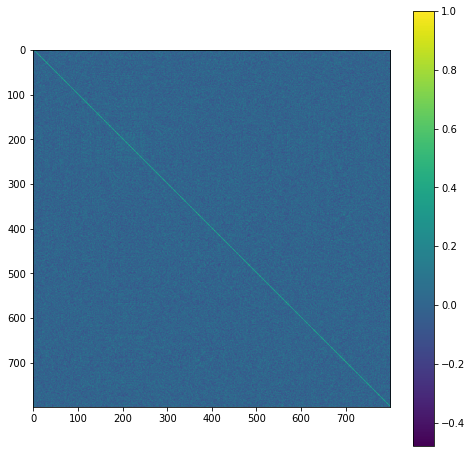

In [12]:
plt.figure(figsize=(8,8))

cls_centers_norm = torch.nn.functional.normalize(cls_centers, dim=1)

ccos_cnc = torch.matmul(cls_centers_norm,cls_centers_norm.transpose(0,1)).cpu()
im = plt.imshow(ccos_cnc)
plt.colorbar(im)
print(cls_centers[0].norm(2))

In [25]:
all_sim_spks = []
for i in range(len(ccos_cnc)):
    this_spk = ccos_cnc[i]
    sim_spks = torch.argsort(this_spk)[-8:].tolist()
#     sim_spks.extend([i])
    all_sim_spks.append(sim_spks)
    
all_sim_spks = torch.LongTensor(all_sim_spks)

In [26]:
all_sim_spks

tensor([[543,  10, 252,  ..., 297, 699,   0],
        [786, 374, 649,  ..., 562, 489,   1],
        [ 28, 294, 486,  ...,  90, 222,   2],
        ...,
        [722,  37, 644,  ..., 676, 555, 797],
        [335, 317, 459,  ..., 702,  70, 798],
        [115, 527, 719,  ..., 544, 206, 799]])

In [21]:
torch.unique(all_sim_spks.reshape(-1)).shape

torch.Size([800])

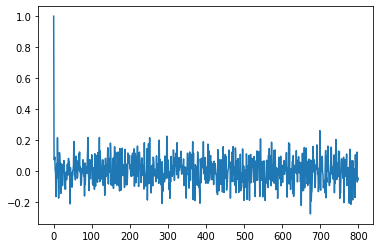

In [13]:
plt.plot(ccos_cnc[0])
# plt.plot(ccos[1])
# plt.plot(ccos[2])

In [14]:
ckp = torch.load(script_dir+'/'+'Data/checkpoint/ThinResNet18/vox1/klfb_egs_baseline/arcsoft_sgd_rop/chn32_Mean_basic_v2_downk5_none1_SAP2_dp125_alpha0_em256_wd5e4_var/checkpoint_50.pth')
print(list(ckp['state_dict'].keys())[-1])
cls_centers = ckp['state_dict']['classifier.W']
cls_centers = cls_centers.transpose(0,1)
print(cls_centers.shape)

classifier.W
torch.Size([1211, 256])


tensor(0.2616, device='cuda:0')


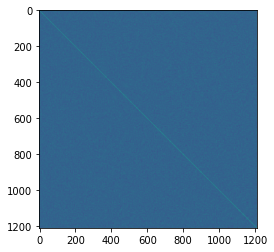

In [15]:
cls_centers_norm = torch.nn.functional.normalize(cls_centers, dim=1)

ccos_vox1 = torch.matmul(cls_centers_norm, cls_centers_norm.transpose(0,1)).cpu()
plt.imshow(ccos_vox1)

print(cls_centers[0].norm(2))

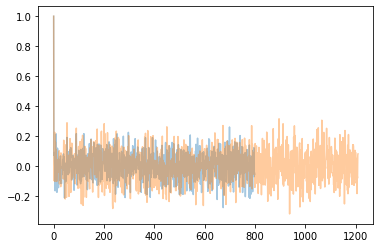

In [16]:
plt.plot(ccos_cnc[0], alpha=0.4)
plt.plot(ccos_vox1[0], alpha=0.4)

# plt.plot(ccos[1])
# plt.plot(ccos[2])

In [17]:
attention_model =  torch.nn.Sequential(
    SelfAttentionPooling_v2(input_dim=256, hidden_dim=128),
#     torch.nn.BatchNorm1d(256),
    )

ce = torch.nn.MSELoss()
attention_model = attention_model.cuda()

optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8,], gamma=0.1)

attention_model.train()
epochs = 12
total_loss = []
for e in range(epochs):
    epoch_loss = []
    for batch_idx, (data, label, data_length) in enumerate(train_loader):
        #print(data.data.shape)
        data = data.cuda()
        label = cls_centers[label].cuda()

        centers = attention_model(data)
        loss = ce(centers, label)
        epoch_loss.append(float(loss.item()))

        loss.backward()
        optimizer.step()  # update parameters of net
        optimizer.zero_grad()  # reset gradient

    print('Epoch %d loss: %f'%(e, np.mean(epoch_loss)))
            
    scheduler.step()
    total_loss.append(epoch_loss)
    
# plt.plot(total_loss)
    

Epoch 0 loss: 0.031727
Epoch 1 loss: 0.028573
Epoch 2 loss: 0.028340
Epoch 3 loss: 0.028576
Epoch 4 loss: 0.028582
Epoch 5 loss: 0.028937
Epoch 6 loss: 0.028022
Epoch 7 loss: 0.028051
Epoch 8 loss: 0.028347
Epoch 9 loss: 0.028330
Epoch 10 loss: 0.027407
Epoch 11 loss: 0.028174


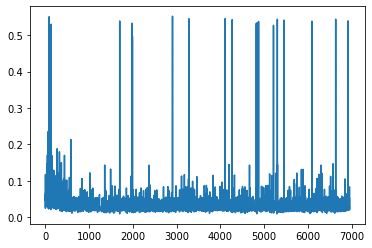

In [19]:
plt.plot(total_loss[0])

In [20]:
with open(script_dir+'/'+'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test/xvectors.scp', 'r') as f:
    attention_model.eval()
    dest_dir = 'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test_centers/'
    with kaldiio.WriteHelper('ark,scp:%s,%s'% (script_dir+'/'+dest_dir+'xvectors.ark', script_dir+'/'+dest_dir+'xvectors.scp'), compression_method=None) as w:                  
        for line in f.readlines():
            uid,upath = line.split()
            uvectors = kaldiio.load_mat(script_dir + '/'+upath)
            uvectors = torch.FloatTensor(uvectors).cuda()
            center = attention_model(uvectors.unsqueeze(0))
#             print(center.shape)
            w(uid, center.detach().cpu().squeeze().numpy())  

In [21]:
test_centers = 'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test_centers'
test_dir = ScriptVerifyDataset(dir=lstm_dir+'/data/cnceleb/klfb/test_fb40', 
                               trials_file='trials', 
                               xvectors_dir=script_dir+'/'+test_centers,
                               loader=kaldiio.load_mat)
test_loader = torch.utils.data.DataLoader(test_dir, batch_size=16 * 64, shuffle=False, **kwargs)

eer, eer_threshold, mindcf_01, mindcf_001 = verification_test(test_loader, dist_type='cos', 
                  log_interval=100, xvector_dir=script_dir+'/'+test_centers, epoch=60)

print(eer)

/home/yangwenhao/local/project/SpeakerVerification-pytorch/TrainAndTest/common_func.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_a = torch.tensor(data_a).cuda()  # .view(-1, 4, embedding_size)
/home/yangwenhao/local/project/SpeakerVerification-pytorch/TrainAndTest/common_func.py:357: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_p = torch.tensor(data_p).cuda()  # .view(-1, 4, embedding_size)


0.1412561029738127


In [49]:
# 1 epoch
# 0.1349312028406569

# 15 epoech
# 0.18203506435863293'

# 15 epoech remove bn
# 0.13920328450954284

# 12 epoech remove bn
# 0.13903683976919662

0.13920328450954284


In [2]:
sims = [ 4.7618e-01,  9.6951e-02, -1.0506e-01, -3.0528e-02,  1.7709e-01,
         -7.2116e-02, -7.6291e-02,  3.5862e-02, -1.0262e-01,  4.9079e-02,
          1.2554e-01, -2.9550e-02,  4.8768e-02,  3.0198e-02, -3.1262e-02,
          2.8889e-01,  3.2923e-02,  1.7090e-02, -5.9057e-02,  9.4558e-02,
          9.7931e-02, -9.2381e-02, -1.1895e-01,  2.1141e-01, -5.1191e-02,
         -2.2098e-02,  1.7467e-01, -9.1557e-03, -1.0679e-01, -1.4928e-01,
          2.8033e-02,  2.5532e-01,  2.6497e-01, -8.8322e-02,  1.1387e-01,
          9.4491e-02,  1.1824e-01,  6.4730e-02, -6.9368e-02, -2.6886e-02,
         -1.2693e-01, -4.2992e-02,  1.2275e-01,  9.8722e-02, -1.9431e-01,
          3.3160e-02,  4.4949e-02,  1.6696e-01,  2.1659e-02,  1.6450e-01,
         -6.5950e-02,  1.3009e-01, -7.5356e-03,  1.6718e-01, -8.5694e-02,
         -3.5946e-02, -1.8374e-01,  1.4626e-02,  7.8392e-02,  7.1406e-02,
         -1.5480e-02,  8.4528e-02,  3.3223e-02, -1.4085e-01,  2.3974e-02,
         -4.3396e-02,  2.3935e-01,  1.2917e-01, -8.9085e-02,  2.8260e-02,
          1.5093e-01, -2.3932e-02, -1.6206e-01,  1.1402e-01, -5.7755e-02,
         -2.5948e-01,  3.7761e-02,  1.5038e-01,  1.7190e-01, -1.4258e-01,
          2.1039e-02,  2.4895e-01, -9.5929e-02, -1.0565e-01,  6.5891e-03,
          2.2433e-01, -3.9254e-02,  2.3295e-02,  2.2584e-01,  1.3472e-01,
          1.8015e-01, -1.1166e-01, -1.3037e-01,  2.4923e-02, -2.4913e-02,
         -7.8034e-02,  1.7716e-01, -9.2356e-02, -7.3854e-02,  1.7581e-01,
          8.0553e-02, -8.8963e-03, -7.4496e-02, -7.6514e-02,  7.0640e-02,
         -1.0915e-02, -6.5159e-02, -2.8936e-02, -1.9916e-02, -7.3227e-02,
         -4.0645e-02,  1.0284e-01, -6.0820e-02,  2.3320e-01, -7.7537e-02,
          7.0067e-02, -2.9203e-02, -1.8059e-02, -1.0523e-01,  1.6409e-01,
         -1.4719e-02, -9.6791e-02,  1.5579e-01, -4.1612e-02,  1.7062e-02,
         -1.6788e-01, -5.1397e-02,  1.5431e-01, -8.9811e-02,  3.2247e-01,
          1.9024e-01, -2.6994e-02, -2.6427e-03, -4.5412e-02,  3.0518e-03,
         -9.8368e-02, -1.7118e-01, -2.2168e-02,  1.0741e-01,  1.2126e-01,
          5.8660e-02, -1.0315e-01, -1.0195e-01,  5.3932e-02,  3.0018e-02,
          6.9535e-02,  3.4779e-02,  3.1705e-02, -7.8105e-02, -1.0322e-01,
         -1.6001e-01, -1.1262e-01,  1.4357e-01,  3.7881e-01,  1.6186e-01,
          7.4971e-02, -1.1866e-01,  4.4500e-02,  4.4310e-04,  3.2229e-01,
          1.7567e-01,  5.9809e-02, -1.2161e-03, -2.2981e-02,  4.5525e-02,
         -2.6240e-02, -6.8621e-03, -1.6953e-02,  3.1183e-02,  1.1076e-01,
          6.0102e-02,  3.7642e-03,  7.0786e-02, -1.3255e-02, -7.0655e-02,
         -3.7299e-06, -6.0959e-02,  7.2042e-02,  7.2945e-02,  1.3520e-01,
          2.0695e-01, -7.0547e-02, -1.6665e-01,  6.5871e-02, -4.3060e-02,
          1.7084e-01, -4.4965e-02,  2.1456e-03,  3.8671e-03,  2.7496e-01,
         -6.1914e-02, -3.1393e-02,  9.1220e-02,  8.4305e-02,  6.6826e-02,
          3.4945e-01,  1.0273e-01,  1.3629e-01, -5.9010e-02,  6.1704e-02,
          2.9868e-02, -2.6714e-02, -1.0733e-01,  7.1602e-02, -1.5234e-01,
          3.4875e-02,  7.5076e-02,  4.4410e-02,  1.5382e-02,  3.0810e-01,
         -1.3330e-01,  9.5021e-02, -2.7906e-02,  1.7648e-02, -5.4556e-02,
         -1.0482e-01, -8.1199e-02,  1.3869e-01,  1.8856e-01,  2.9174e-01,
          2.5550e-02, -1.4928e-01, -1.9846e-01,  9.2543e-02,  2.4275e-02,
          1.8913e-01,  1.4772e-01,  1.1708e-02, -5.8775e-02,  1.6658e-02,
          2.4056e-02, -8.6010e-02, -1.4101e-02, -1.3993e-01, -4.4728e-02,
          1.7766e-01,  2.3852e-01, -1.6320e-01, -4.1005e-02,  1.8581e-01,
          7.6912e-02, -1.4146e-01, -1.1813e-01,  5.9383e-02,  1.4095e-01,
          5.1710e-02,  3.4137e-02, -1.3522e-03,  2.3567e-01,  2.0447e-01,
          1.7971e-02, -1.0882e-01,  3.4886e-01,  1.3246e-01, -1.8271e-01,
          1.2695e-01, -1.5870e-01,  3.6467e-02,  5.9333e-02, -6.8558e-02,
         -2.2322e-02,  1.1570e-01,  1.1079e-01, -3.6074e-02, -1.9224e-01,
         -2.4076e-03,  6.2463e-02,  8.9179e-02,  8.9529e-02,  1.4305e-01,
          4.9734e-02, -8.5533e-02, -5.7428e-02, -8.1901e-02, -1.7160e-01,
          2.6063e-01, -4.5114e-02, -3.5614e-03,  1.2025e-01,  1.1811e-01,
         -2.6419e-02, -1.2477e-02, -1.2496e-01,  1.5536e-02, -8.6650e-02,
          1.8826e-03,  1.2041e-01, -1.3210e-01, -9.3254e-02,  1.7306e-01,
          7.2745e-02,  1.6798e-01,  5.4216e-02, -1.3600e-02,  9.6694e-02,
          2.6701e-03, -5.2899e-02, -1.1268e-01, -1.1989e-01,  1.9356e-01,
         -2.0691e-02, -1.1732e-02,  3.8917e-03, -7.0278e-02, -3.9205e-02,
          4.8049e-02, -1.7499e-01, -2.4766e-01,  1.9632e-01,  1.2985e-02,
         -5.4494e-03,  1.0587e-02,  1.9440e-02,  4.6083e-02,  2.5661e-01,
          1.3836e-01, -1.4056e-02, -3.2681e-02, -1.1452e-01, -1.4805e-01,
         -1.1890e-01,  1.8740e-01, -1.2832e-01,  1.7340e-01,  4.7673e-02,
         -1.9375e-01,  4.5954e-02,  2.5251e-02,  1.8726e-01, -4.1653e-02,
          2.4308e-05,  5.2972e-03, -9.0940e-05,  2.3613e-02,  5.4168e-02,
          2.2060e-01,  1.6908e-01,  2.4940e-01, -3.1192e-02,  1.7197e-01,
          1.8087e-01,  7.8447e-02,  1.4119e-01,  2.8422e-03, -7.0246e-02,
         -4.8436e-03, -4.1775e-02,  5.5641e-03, -3.7083e-02,  1.5309e-01,
          2.3660e-01,  1.1383e-01, -1.8185e-02,  6.0451e-02, -8.1692e-03,
          2.2338e-02,  2.0605e-01, -1.9501e-01, -1.8029e-01,  1.4922e-01,
          1.9056e-01, -1.8979e-01, -1.0054e-01,  1.3308e-01,  9.6580e-02,
          2.6816e-03,  5.0863e-02,  3.5037e-02,  2.6007e-02, -1.5877e-01,
         -8.4891e-02,  1.0338e-01, -4.8009e-02,  7.4150e-04, -5.9526e-03,
          1.7919e-01, -1.4802e-01,  1.6278e-01,  7.9452e-02, -2.1447e-03,
         -8.9844e-02,  1.4410e-01, -5.3380e-02, -3.1732e-02, -2.4369e-02,
          9.8221e-02, -6.1689e-02, -3.1388e-02,  4.9939e-02,  2.4761e-01,
         -6.4536e-02,  1.3152e-01,  1.5733e-01,  2.0429e-01,  8.1620e-02,
         -1.0983e-01,  1.8612e-01, -1.8133e-02,  1.2706e-01, -1.2912e-01,
          9.2981e-02,  2.3067e-01,  8.3759e-02,  1.3518e-01,  2.0063e-01,
          1.0959e-01,  9.5618e-02,  3.9362e-01, -1.0008e-01,  2.6054e-02,
          1.0112e-01,  1.9165e-01,  4.0356e-02,  1.3966e-01, -7.3509e-02,
          9.8783e-03, -1.2163e-01,  1.1185e-01,  4.2385e-04,  2.2611e-01,
          1.1232e-01,  8.0733e-02, -2.8095e-02, -2.0655e-01, -1.1982e-01,
         -6.1995e-02, -1.4552e-01, -5.5726e-02,  2.4216e-01, -2.3492e-01,
          6.5658e-02, -8.5193e-02, -4.1453e-02, -4.3103e-03, -7.3414e-02,
         -8.6322e-02,  1.5366e-01, -8.8160e-02, -4.5617e-02,  7.8075e-02,
         -1.2024e-02,  5.9294e-02, -6.3437e-02, -1.4015e-01,  3.1966e-01,
          1.6140e-03, -1.3814e-01,  1.3553e-01, -2.2826e-01,  4.8516e-02,
          1.0005e-01,  3.2168e-02, -1.8725e-02,  1.4379e-01, -1.1254e-01,
          8.1920e-02,  2.0453e-01,  1.3237e-01,  7.4117e-02, -2.6521e-01,
          2.6614e-02,  2.3331e-02, -2.0337e-02, -1.4934e-01,  8.8165e-02,
          1.0095e-01,  3.6143e-01,  1.0714e-01, -4.3610e-02, -2.5294e-02,
         -9.4467e-02,  1.3917e-01, -9.8118e-02, -1.2797e-01,  9.7174e-02,
          4.8468e-02,  4.6361e-02,  1.6540e-01,  2.5633e-01,  7.7586e-02,
         -4.0564e-02,  1.5387e-01, -6.9964e-02,  3.6681e-01, -7.0592e-03,
         -2.4515e-01, -1.8041e-01,  1.8017e-01,  2.6992e-02,  1.5870e-01,
         -4.6872e-03,  8.5158e-02,  4.0213e-02, -1.3696e-02,  1.5964e-02,
         -1.1443e-01,  1.6285e-01,  5.9268e-02, -1.6844e-01,  3.9082e-02,
         -6.7979e-02, -1.1180e-01,  1.1864e-01, -1.5042e-01, -1.2596e-01,
          5.2893e-03,  5.0584e-02, -1.9066e-01, -9.2573e-02, -1.6003e-01,
          1.0062e-01, -1.1036e-01,  1.8417e-02,  1.0275e-01,  4.9736e-02,
         -8.4959e-02, -6.9813e-02, -5.6575e-02,  3.1583e-03, -9.2988e-02,
          1.8006e-01, -1.7193e-02, -1.1635e-03, -2.3634e-02, -5.1710e-02,
         -1.2700e-02, -7.0717e-02,  2.6981e-01, -8.4949e-03,  6.2310e-03,
          8.6298e-02,  7.4738e-02,  1.3534e-01, -8.2703e-02, -1.7512e-02,
          1.8534e-01,  2.5660e-01, -4.9504e-02,  6.3357e-02,  2.2068e-02,
          1.6695e-01,  4.5071e-02,  1.2118e-01,  2.2182e-02,  9.5198e-02,
          1.6197e-01, -3.1872e-02, -3.2940e-02, -1.2800e-02,  7.4135e-02,
         -4.2395e-02,  5.2597e-02,  4.6116e-02,  2.4119e-02,  9.2099e-02,
         -3.6209e-02,  5.1173e-02, -1.8731e-01, -7.0007e-02, -3.1127e-02,
          1.1154e-01,  1.2934e-01,  1.5725e-01,  1.6975e-01,  1.3419e-01,
          3.8505e-01,  2.9666e-01,  7.7590e-02,  2.7895e-01,  1.1798e-02,
          1.7807e-01, -8.4175e-02, -1.6997e-01, -1.1460e-01, -8.7841e-02,
         -1.4947e-01,  1.4398e-01,  4.3353e-02, -1.7933e-01,  1.0082e-01,
          5.7772e-02,  1.3912e-01,  1.7448e-01, -1.0032e-02, -1.0002e-01,
         -4.4497e-02,  5.4581e-02,  7.4180e-04,  9.2280e-02,  1.5967e-01,
         -1.3003e-01,  1.2911e-01, -6.2205e-02,  1.8715e-01,  1.9768e-01,
          1.7717e-01, -1.3895e-01,  1.2250e-01, -1.1947e-01, -8.4065e-02,
          9.0907e-03, -1.9837e-02,  1.7784e-01,  2.3142e-01, -6.2067e-02,
         -1.9483e-01,  1.2932e-01,  8.2513e-02,  5.8275e-02,  1.2227e-01,
          2.3314e-01, -6.4782e-02,  1.0707e-02, -2.5913e-02,  2.2303e-01,
          6.4134e-02, -5.4014e-02,  2.3618e-01,  1.6950e-01, -1.0628e-01,
         -1.8304e-01, -1.9203e-04,  8.8990e-02,  1.0709e-01,  1.3716e-01,
          1.4171e-01,  2.2602e-01, -1.8874e-02, -1.7072e-01, -1.3362e-01,
          1.4698e-01,  7.1940e-02, -7.6266e-02,  8.6512e-03,  1.8123e-01,
          4.9933e-02,  4.6955e-02,  9.7543e-02, -3.2722e-02, -7.1229e-02,
         -7.6238e-02, -4.3205e-02,  2.6268e-01,  1.9681e-01,  5.9734e-02,
          1.4668e-02,  1.1180e-01,  4.7079e-02, -1.5704e-01,  5.5866e-02,
          1.0425e-01, -2.2138e-02,  3.8005e-02, -1.9967e-01, -6.6381e-03,
          1.1300e-04,  2.8162e-04, -1.7883e-01, -1.3366e-01,  1.9603e-01,
         -9.4192e-02, -1.0522e-01, -1.8126e-01,  7.7263e-02, -3.3399e-02,
         -2.3093e-01,  4.7517e-02,  1.6631e-01,  1.3911e-01,  4.5292e-02,
          1.1027e-01,  2.6182e-01, -1.0012e-01,  3.0725e-02,  9.1612e-02,
         -2.5605e-01,  1.4857e-01,  8.3381e-02, -8.9868e-02,  4.1674e-02,
         -9.7605e-02, -1.8450e-01, -1.5062e-01, -5.1763e-02,  2.0051e-01,
         -9.0975e-02,  4.8210e-02, -1.6272e-01, -1.6322e-01,  6.0908e-02,
         -1.0948e-01, -2.0957e-02, -1.6079e-01, -1.4770e-01, -1.4640e-01,
          4.5956e-02, -2.3235e-01,  8.6245e-02,  2.3655e-02,  8.4916e-02,
          6.5277e-02, -1.0666e-01, -2.5746e-01, -1.9229e-01,  9.9433e-02,
         -1.8312e-02, -2.6956e-01, -2.2403e-01,  1.6792e-01, -7.3826e-02,
          9.8160e-02,  3.2249e-02,  5.3579e-02, -1.4452e-02, -1.6158e-01,
         -1.7275e-01, -4.4095e-02,  9.6294e-02,  1.8358e-01,  6.4703e-03,
         -4.0991e-02,  7.3743e-02,  4.2919e-02, -1.0977e-01,  6.2311e-02,
          1.3612e-01, -1.1455e-01, -8.7907e-02,  1.7363e-01, -4.1659e-02,
          1.7958e-01,  1.5969e-02,  2.4243e-01,  1.0898e-01,  6.4119e-02,
         -6.7061e-02,  3.2068e-01,  1.6733e-01,  1.3841e-01,  6.7717e-02,
          8.5833e-02, -9.9933e-02, -2.1636e-02, -9.3277e-02, -4.8212e-03,
         -1.3686e-01,  2.0031e-02,  9.9563e-02, -2.3863e-01, -6.7638e-02,
         -1.4944e-01, -1.8145e-01, -1.4990e-01,  6.6878e-02,  1.2192e-01,
         -1.5172e-01, -2.5258e-01,  5.9622e-02, -1.7453e-02,  2.7316e-02,
          6.0034e-02,  1.2973e-01,  5.8104e-02,  5.5481e-02, -4.9955e-02,
          1.9105e-02,  1.1182e-02,  2.5848e-01,  4.7573e-02, -5.2524e-02,
         -3.8258e-02,  8.2994e-02, -1.5242e-01,  2.7507e-01, -1.7828e-02,
          1.6315e-01, -1.7221e-02, -6.6209e-02,  3.7730e-02, -1.2796e-01,
         -7.3366e-02, -1.2168e-01, -4.1078e-02,  1.0350e-01,  8.0951e-02,
          1.9268e-02, -4.0238e-02,  2.1918e-01,  4.0165e-02, -1.1527e-01,
          8.8169e-03,  1.0129e-01,  1.8076e-01, -1.7907e-02,  2.0054e-02,
          2.0903e-01, -5.4617e-02]

(array([ 18.,  77., 137., 196., 169., 115.,  56.,  21.,   7.,   1.]),
 array([-0.26956 , -0.194986, -0.120412, -0.045838,  0.028736,  0.10331 ,
         0.177884,  0.252458,  0.327032,  0.401606,  0.47618 ]),
 <BarContainer object of 10 artists>)

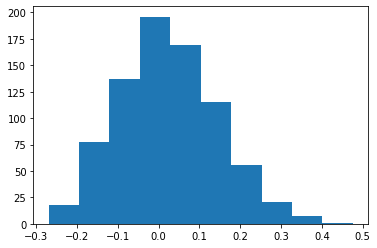

In [3]:
plt.hist(sims)

In [22]:
# scp data/cnceleb/egs/klfb/dev_fb40/idx2spk yangwenhao@172.26.114.86:/home/work2020/yangwenhao/project/SpeakerVerification-pytorch/Data/xvector/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_varesmix2_bashuf2_dist/123456

spk2idx = {}
idx_file = script_dir + '/' + 'Data/xvector/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_varesmix2_bashuf2_dist/123456/idx2spk'
with open(idx_file, 'r') as f:
    for l in f.readlines():
        idx, spk= l.split()
        spk2idx[spk] = int(idx)

In [ ]:
spk2idx

In [119]:
epochs = [1, 2, 5, 6, 9, 10, 12, 13, 17, 20, 21, 25, 26, 27, 29, 30, 33, 37, 40, 41]
# < 25 0.1
# < 35 0.01
# < 41 0.001
# = 41 0.0001
target_score_dict = {}
for i,epoch in enumerate(epochs):

    target_dict = {}
    xvector_path = 'Data/xvector/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_varesmix2_bashuf2_dist/123456/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
    with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
        for key, numpy_array in reader:
            # print(numpy_array)
            # break
            # id00000-singing-01-001
            spk = key.split('-')[0]
            idx = spk2idx[spk]
            # print(idx)

            if idx in target_dict:
                target_dict[idx].append(numpy_array[idx])
            else:
                target_dict[idx] = [numpy_array[idx]]
    
    target_score = []
    for idx in target_dict:
        target_score.extend(target_dict[idx])
    
    target_score_dict[epoch] = target_score


gzip: /home/work2020/yangwenhao/project/SpeakerVerification-pytorch/Data/xvector/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_varesmix2_bashuf2_dist/123456/cnceleb_dev_10_fix/test/sim.ark.gz: not in gzip format


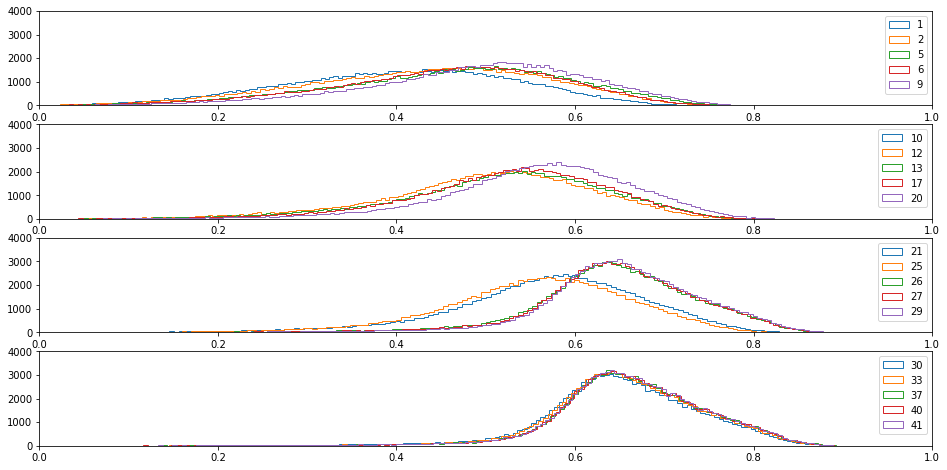

In [87]:
plt.figure(figsize=(16,8))

for i,epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    plt.subplot(4, 1, int(i//5+1))
    _ = plt.hist(target_score, bins=200, histtype='step')
    
    if i%5==4:
        plt.xlim(0,1)
        plt.ylim(0, 4000)
        plt.legend(epochs[(i-4):(i+1)])

In [111]:
solors = ['#fff7f5', '#fff3f0', '#ffefeb', '#ffebe6', '#fee7e0', '#fee3db', '#fedfd6', '#fedcd1', '#fed8cc', '#fed4c7', '#fed0c2', '#feccbd', '#fec8b8', '#fec4b3', '#fdc0ad', '#fdbca8', '#fdb8a3', '#fdb49e', '#fdb099', '#fdac94', '#fda88f', '#fda48a', '#fda085', '#fd9d80', '#fc997a', '#fc9575', '#fc9170', '#fc8d6b', '#fc8966', '#fc8561', '#fc815c', '#fc7d57', '#fc7952', '#fc754d', '#fb7147', '#fb6d42', '#fb693d', '#fb6538', '#fb6133', '#fb5d2e', '#fb5a29', '#fb5624', '#fb521f', '#fb4e19', '#fa4a14', '#fa460f', '#fa420a', '#fa3e05', '#fa3a00', '#f53900', '#f03800', '#eb3700', '#e63500', '#e13400', '#dc3300', '#d73200', '#d23100', '#cd3000', '#c82e00', '#c32d00', '#be2c00', '#b92b00', '#b42a00', '#af2900', '#aa2700', '#a52600', '#a02500', '#9b2400', '#962300', '#912200', '#8c2000', '#871f00', '#821e00', '#7d1d00', '#781c00', '#731b00', '#6e1a00', '#691800', '#641700']

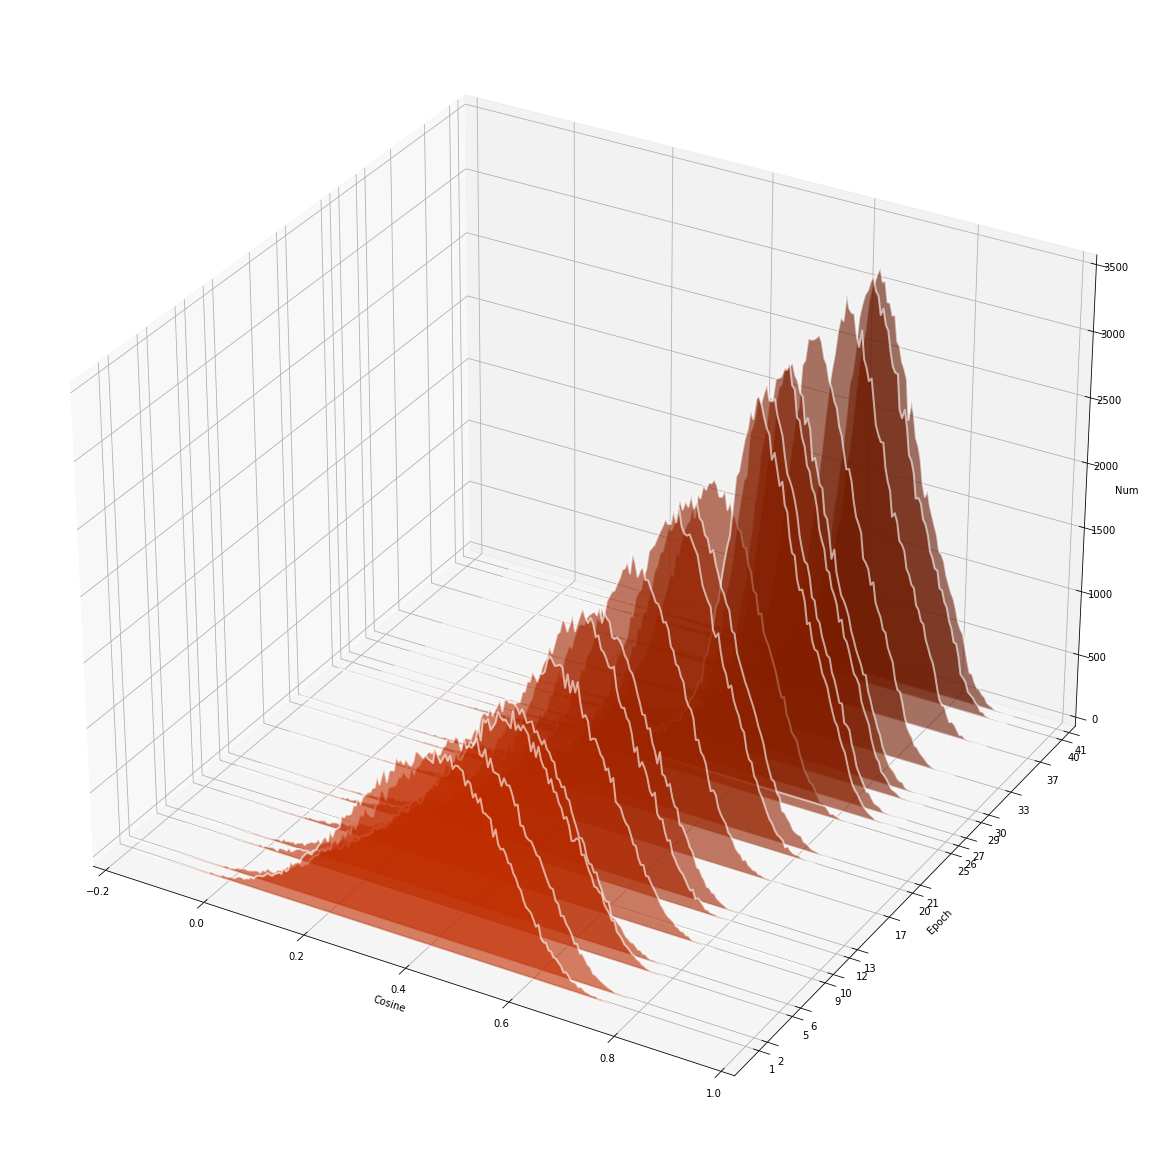

In [118]:
ax = plt.figure(figsize=(21, 21)).add_subplot(projection='3d')

# Make verts a list such that verts[i] is a list of (x, y) pairs defining
# polygon i.
verts = []

# The ith polygon will appear on the plane y = zs[i]
zs = epochs
    
for i, epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    
    hists, edgs = np.histogram(target_score, bins=200)
    # plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
    # plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists

    verts.append(polygon_under_graph(xs, ys))


poly = PolyCollection(verts, facecolors=solors[-len(verts):], edgecolors=("white",), alpha=.6, linewidths=2.0)
ax.add_collection3d(poly, zs=[i-1 for i in zs], zdir='y')

ax.set_xlabel('Cosine')
ax.set_ylabel('Epoch')
ax.set_zlabel('Num')
ax.set_yticks(zs)
ax.set_xlim(-0.2, 1)
ax.set_ylim(-1, 41)
ax.set_zlim(0, 3500)

plt.show()



(0.0, 1.0)

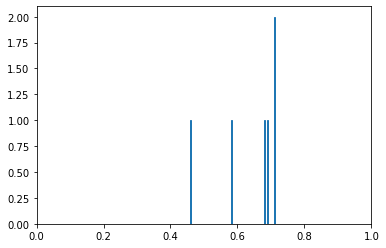

In [39]:
_ = plt.hist(target_dict[0], bins=100, histtype='step') #'bar', 'barstacked', 'step', 'stepfilled'
plt.xlim(0,1)

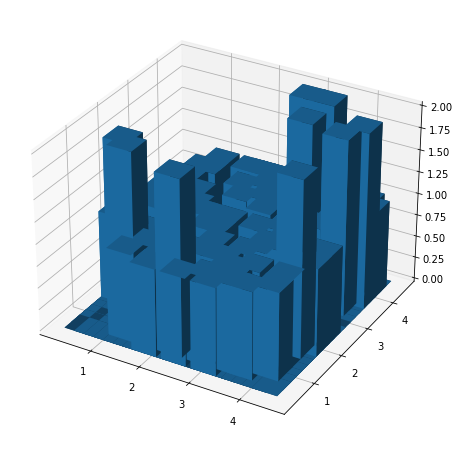

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=20, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

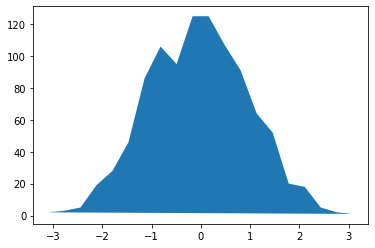

In [77]:
hists, edgs = np.histogram(np.random.randn(1000), bins=20)
# plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
# plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
plt.fill((edgs[:-1]+edgs[1:])/2, hists)

In [66]:
np.random.randn(100)

array([-0.02780867,  0.02901073, -0.83888336, -0.99760924,  0.19685337,
       -1.56702295,  0.0768129 ,  0.22949381,  1.1644726 ,  0.01356057,
       -1.13170017, -0.69851989, -1.28332743, -1.03435213,  0.85872169,
       -1.12860543,  0.42509672,  1.01614134, -3.13862515, -0.49203063,
        1.61015246,  0.47397762, -2.31153107, -0.45318115, -0.83166942,
       -0.26312953, -0.25337446,  0.10464099, -0.33843749, -1.14802757,
       -0.52772188, -0.12081065,  0.17428587, -0.6388964 , -0.08507843,
        1.6268965 ,  0.7295082 ,  0.38736836,  0.1360746 ,  0.15859345,
       -0.08736462, -0.73117122,  1.24671148,  0.71234305, -1.17256327,
        0.43895157, -0.52569814,  0.45214682,  0.82944754,  2.10292241,
        0.51104017,  2.14102966, -0.61323254,  2.0560547 , -0.02445903,
        1.68287675,  1.10886189,  0.95530773, -0.44130503, -0.4628945 ,
        1.09308575, -1.37670976,  0.21817146, -2.19149574,  0.9015237 ,
        1.91538862,  0.98552188,  0.1929464 , -0.39100285, -0.77

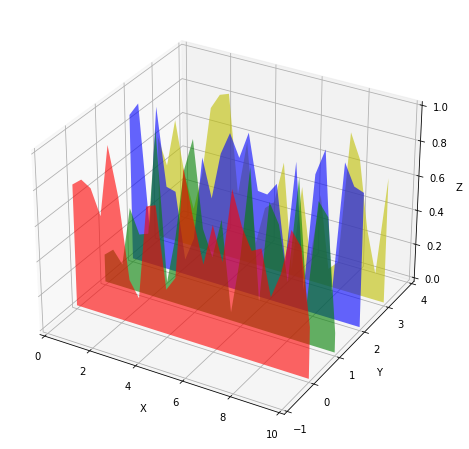

In [84]:
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]


ax = plt.figure(figsize=(16,8)).add_subplot(projection='3d')

# Make verts a list such that verts[i] is a list of (x, y) pairs defining
# polygon i.
verts = []

# Set up the x sequence
xs = np.linspace(0., 10., 26)

# The ith polygon will appear on the plane y = zs[i]
zs = range(4)

for i in zs:
    ys = np.random.rand(len(xs))
    verts.append(polygon_under_graph(xs, ys))

poly = PolyCollection(verts, facecolors=['r', 'g', 'b', 'y'], alpha=.6)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, 10)
ax.set_ylim(-1, 4)
ax.set_zlim(0, 1)

plt.show()